# Model validation

This notebook is used to validate the model. The verification procedures used in this notebook are taken from the [Agent based modelling for Socio-technical systems](https://www.ieeexplore.ieee.org/abstract/document/5874914/?casa_token=2LsDXcW6KKYAAAAA:4amVur3NmeHReBI3lNurs53tghVKB7vT75ju74f9WNQwBKLAeWPBvPFuXvLi4Gww2LnxFYoGNJ0)
The objective of these validation checks is to confirm if 'fit-for-purpose' to answer the research questions.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from model.model_code import *
from results.results import *

## Community setup for model validation
These tests will be performed on a simple energy community with 30 households and one school. The school owns a Solar PV system and two households also have solar rooftop installed on them.

In [2]:
# Setup residential members

number_of_households = 10
# picking household type randomly
hh_type = ['hh1_consumption [kWh]', 'hh2_consumption [kWh]', 'hh3_consumption [kWh]']
residential_agents = []
for i in range(number_of_households):
    if i == 9 or i == 8:
        assets = [{'agent_type': Asset,
                   'asset_type': Solar,
                   'capacity': 5,
                   'efficiency': 0.20,
                   'price': 0.15}]
        agent_type = AgentType.PROSUMER
    else:
        assets = None
        agent_type = AgentType.CONSUMER
    residential_agents.append({'member_name': random.choice(hh_type),
                               'member_type': MemberType.RESIDENTIAL,
                               'agent_type': agent_type,
                               'demand_flexibility': 0.20,
                               'asset_list': assets})

In [3]:
# Setup Non-residential member (School)
non_residential_agents = [{'member_type': MemberType.NON_RESIDENTIAL,
                           'member_name': 'school_mbo',
                           'agent_type': AgentType.PROSUMER,
                           'demand_flexibility': 0.20,
                           'asset_list': [{'agent_type': Asset,
                                           'asset_type': Solar,
                                           'capacity': 200,
                                           'efficiency': 0.20,
                                           'price': 0.15}]}]

In [4]:
# Setup community coordinator
coordinator = [{'member_type': MemberType.COORDINATOR}]

In [5]:
# Combine residential and non-residential agents
agent_list = residential_agents + non_residential_agents + coordinator

## 1. Micro validation

The micro-validation is performed by evaluating the agent behaviour under extreme values of lever and uncertainties. If the agent exhibits plausible and explainable behaviours, the test outcomes are positive.

### 1.1 Extreme lever test

In [6]:
# set extreme low and extreme high lever values
levers_low = {"L1": 0,
              # Percentage of members participating in the demand response program (Social)
              "L2": 0.1,
              # Percentage of flexible (shift-able)  demand for residential community members (Technical)
              "L3": 0.1,
              # Percentage of flexible (shift-able)  demand for non-residential community members (Technical)
              }

levers_high = {"L1": 1,
               # Percentage of members participating in the demand response program (Social)
               "L2": 0.9,
               # Percentage of flexible (shift-able)  demand for residential community members (Technical)
               "L3": 0.9,
               # Percentage of flexible (shift-able)  demand for non-residential community members (Technical)
               }

In [7]:
model = EnergyCommunity(levers=levers_low,
                        uncertainties=None,  #Default values
                        agents_list=agent_list,
                        start_date=None)  # Default values

In [8]:
results = model.run_simulation(steps=365, time_tracking=True)

Run time: 32.97 seconds
Simulation completed!


In [9]:
df = pd.DataFrame()
for item in results['M1: realised_demand']:
    df = df.append(item, ignore_index=True)
df['date'] = pd.to_datetime(results['date'], format='%Y-%m-%d')
df = df[1:]
df.set_index('date', inplace=True)

total_generation = extract_df_from_json(results, 'M4: total_generation')
total_generation['date'] = pd.to_datetime(total_generation['date'], format='%Y-%m-%d')
total_generation.set_index('date', inplace=True, drop=True)

residential = df.columns.to_list()[:-1]
non_residential = df.columns.to_list()[-1:]

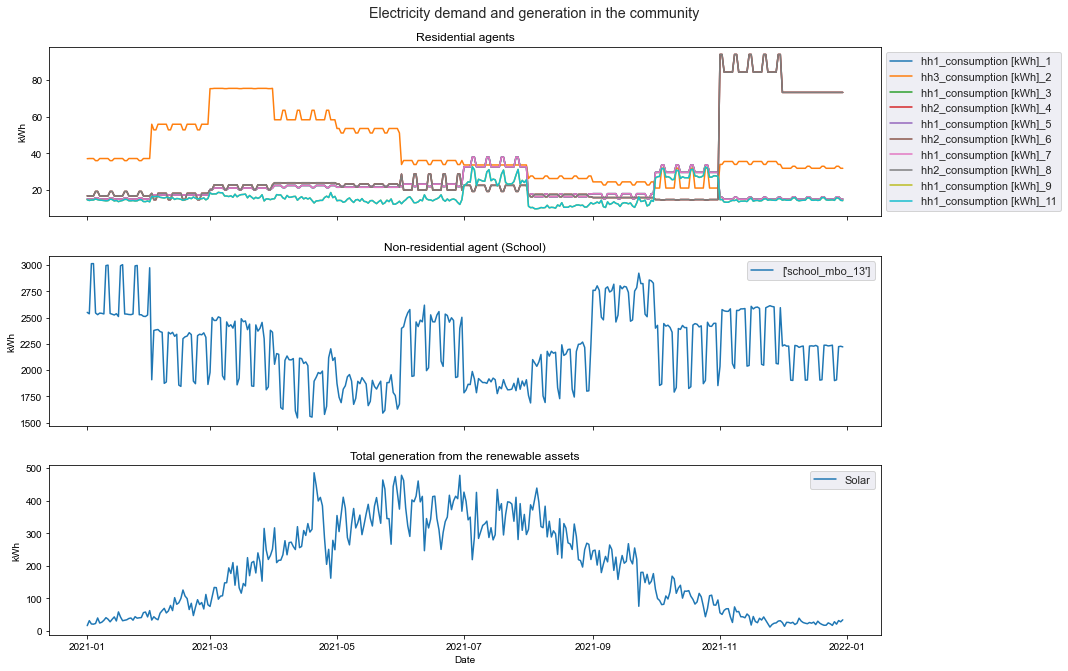

In [10]:
fig, axs = plt.subplots(3, 1, figsize=(15, 9.5), sharex=True)
sns.set_theme(palette='colorblind')
axs[0].plot(df[residential], label=residential)
axs[0].title.set_text('Residential agents')

axs[1].plot(df[non_residential], label=non_residential)
axs[1].title.set_text('Non-residential agent (School)')

axs[2].plot(total_generation, label='Solar')
axs[2].title.set_text('Total generation from the renewable assets')

plt.xlabel('Date')
axs[0].set_ylabel('kWh')
axs[1].set_ylabel('kWh')
axs[2].set_ylabel('kWh')
fig.suptitle('Electricity demand and generation in the community')

axs[0].legend(bbox_to_anchor=(1, 1))
axs[1].legend()
axs[2].legend()

plt.tight_layout()
fig.savefig('figures_validation/micro_extreme_low_lever_demand_generation.png', dpi=300)


In [11]:
shifted_load = extract_df_from_json(results, 'M3: shifted_load')
shifted_load['date'] = pd.to_datetime(shifted_load['date'], format='%Y-%m-%d')
shifted_load.set_index('date', inplace=True, drop=True)

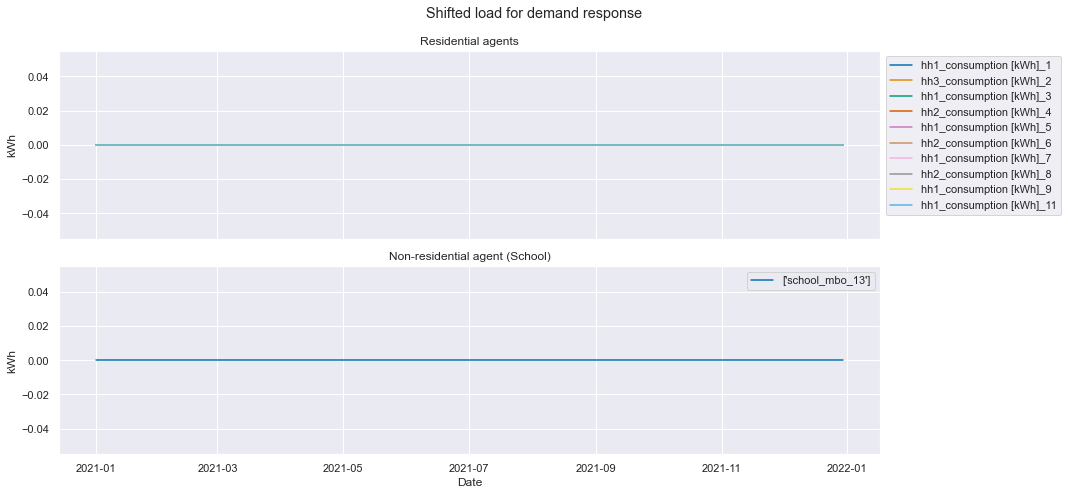

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(15, 7), sharex=True)
sns.set_theme(palette='colorblind')
axs[0].plot(shifted_load[residential], label=residential)
axs[0].title.set_text('Residential agents')
axs[1].plot(shifted_load[non_residential], label=non_residential)
axs[1].title.set_text('Non-residential agent (School)')
plt.xlabel('Date')
axs[0].set_ylabel('kWh')
axs[1].set_ylabel('kWh')
fig.suptitle('Shifted load for demand response')

axs[0].legend(bbox_to_anchor=(1, 1))
axs[1].legend()

plt.tight_layout()
fig.savefig('figures_validation/micro_extreme_low_lever_shifted_load.png', dpi=300)

In [13]:
energy_costs = extract_df_from_json(results, 'M6: energy_costs')
energy_costs['date'] = pd.to_datetime(energy_costs['date'], format='%Y-%m-%d')
energy_costs.set_index('date', inplace=True, drop=True)

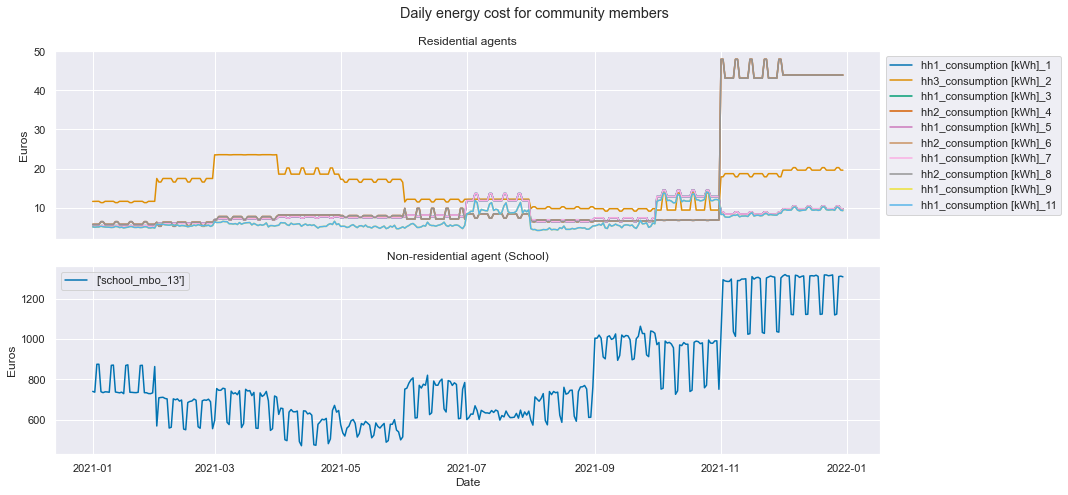

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(15, 7), sharex=True)
sns.set_theme(palette='colorblind')
axs[0].plot(energy_costs[residential], label=residential)
axs[0].title.set_text('Residential agents')
axs[1].plot(energy_costs[non_residential], label=non_residential)
axs[1].title.set_text('Non-residential agent (School)')
plt.xlabel('Date')
axs[0].set_ylabel('Euros')
axs[1].set_ylabel('Euros')
fig.suptitle('Daily energy cost for community members')

axs[0].legend(bbox_to_anchor=(1, 1))
axs[1].legend()

plt.tight_layout()
fig.savefig('figures_validation/micro_extreme_low_lever_electricity_cost.png', dpi=300)

### Performing test for another set of extreme levers

In [15]:
model = EnergyCommunity(levers=levers_high,
                        uncertainties=None,  #Default values
                        agents_list=agent_list,
                        start_date=None)  # Default values

In [16]:
results = model.run_simulation(steps=365, time_tracking=True)

Run time: 41.57 seconds
Simulation completed!


In [17]:
df = pd.DataFrame()
for item in results['M1: realised_demand']:
    df = df.append(item, ignore_index=True)
df['date'] = pd.to_datetime(results['date'], format='%Y-%m-%d')
df = df[1:]
df.set_index('date', inplace=True)

total_generation = extract_df_from_json(results, 'M4: total_generation')
total_generation['date'] = pd.to_datetime(total_generation['date'], format='%Y-%m-%d')
total_generation.set_index('date', inplace=True, drop=True)

residential = df.columns.to_list()[:-1]
non_residential = df.columns.to_list()[-1:]

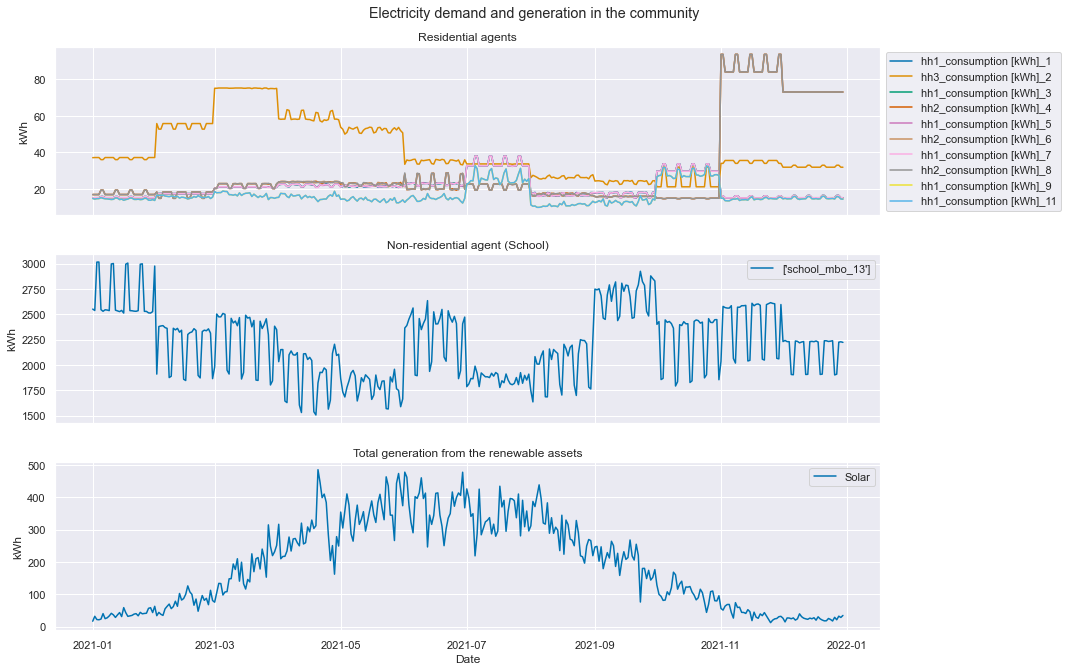

In [18]:
fig, axs = plt.subplots(3, 1, figsize=(15, 9.5), sharex=True)
sns.set_theme(palette='colorblind')
axs[0].plot(df[residential], label=residential)
axs[0].title.set_text('Residential agents')

axs[1].plot(df[non_residential], label=non_residential)
axs[1].title.set_text('Non-residential agent (School)')

axs[2].plot(total_generation, label='Solar')
axs[2].title.set_text('Total generation from the renewable assets')

plt.xlabel('Date')
axs[0].set_ylabel('kWh')
axs[1].set_ylabel('kWh')
axs[2].set_ylabel('kWh')
fig.suptitle('Electricity demand and generation in the community')

axs[0].legend(bbox_to_anchor=(1, 1))
axs[1].legend()
axs[2].legend()

plt.tight_layout()
fig.savefig('figures_validation/micro_extreme_high_lever_demand_generation.png', dpi=300)

In [19]:
shifted_load = extract_df_from_json(results, 'M3: shifted_load')
shifted_load['date'] = pd.to_datetime(shifted_load['date'], format='%Y-%m-%d')
shifted_load.set_index('date', inplace=True, drop=True)

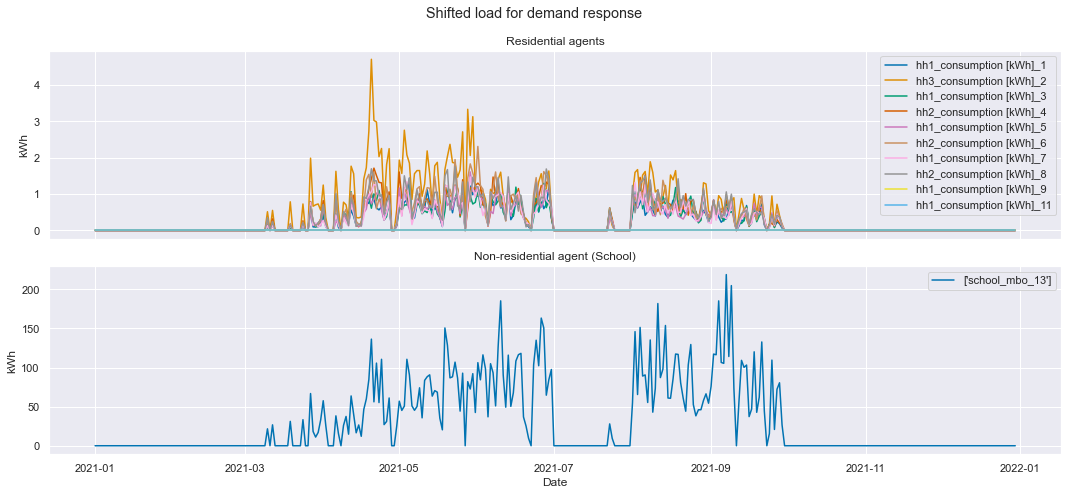

In [20]:
fig, axs = plt.subplots(2, 1, figsize=(15, 7), sharex=True)
sns.set_theme(palette='colorblind')
axs[0].plot(shifted_load[residential], label=residential)
axs[0].title.set_text('Residential agents')
axs[1].plot(shifted_load[non_residential], label=non_residential)
axs[1].title.set_text('Non-residential agent (School)')
plt.xlabel('Date')
axs[0].set_ylabel('kWh')
axs[1].set_ylabel('kWh')
fig.suptitle('Shifted load for demand response')

axs[0].legend(bbox_to_anchor=(1, 1))
axs[1].legend()

plt.tight_layout()
fig.savefig('figures_validation/micro_extreme_high_lever_shifted_load.png', dpi=300)

In [21]:
energy_costs = extract_df_from_json(results, 'M6: energy_costs')
energy_costs['date'] = pd.to_datetime(energy_costs['date'], format='%Y-%m-%d')
energy_costs.set_index('date', inplace=True, drop=True)

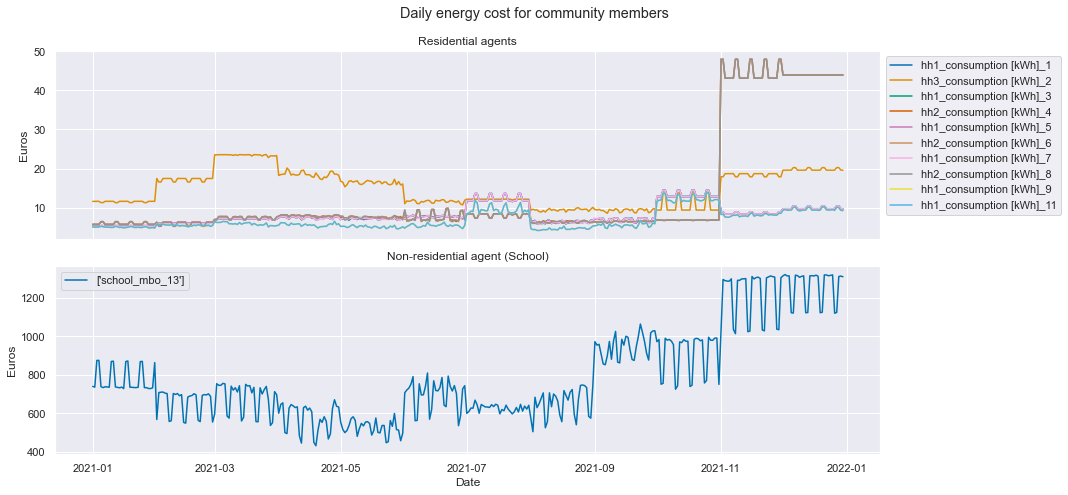

In [22]:
fig, axs = plt.subplots(2, 1, figsize=(15, 7), sharex=True)
sns.set_theme(palette='colorblind')
axs[0].plot(energy_costs[residential], label=residential)
axs[0].title.set_text('Residential agents')
axs[1].plot(energy_costs[non_residential], label=non_residential)
axs[1].title.set_text('Non-residential agent (School)')
plt.xlabel('Date')
axs[0].set_ylabel('Euros')
axs[1].set_ylabel('Euros')
fig.suptitle('Daily energy cost for community members')

axs[0].legend(bbox_to_anchor=(1, 1))
axs[1].legend()

plt.tight_layout()
fig.savefig('figures_validation/micro_extreme_high_lever_electricity_costs.png', dpi=300)

### 1.2 Extreme uncertainty test

In [23]:
# Set extreme high and extreme low uncertainty values
uncertainties_low = {"X1": 0.1,
                     # Minimum percentage of flexible demand available for demand response on a single day (Social)
                     "X2": 0.5,
                     # Maximum percentage of flexible demand available for demand response on a single day (Social)
                     "X3": 0.1,
                     # Percentage accuracy of day-ahead generation projections from renewable assets (Technical)
                     }

uncertainties_high = {"X1": 0.8,
                      # Minimum percentage of flexible demand available for demand response on a single day (Social)
                      "X2": 0.9,
                      # Maximum percentage of flexible demand available for demand response on a single day (Social)
                      "X3": 0.9,
                      # Percentage accuracy of day-ahead generation projections from renewable assets (Technical)
                      }

In [24]:
model = EnergyCommunity(levers=None,  # Default values
                        uncertainties=uncertainties_low,
                        agents_list=agent_list,
                        start_date=None)  # Default values

In [25]:
results = model.run_simulation(steps=365, time_tracking=True)

Run time: 37.5 seconds
Simulation completed!


In [26]:
df = pd.DataFrame()
for item in results['M1: realised_demand']:
    df = df.append(item, ignore_index=True)
df['date'] = pd.to_datetime(results['date'], format='%Y-%m-%d')
df = df[1:]
df.set_index('date', inplace=True)

total_generation = extract_df_from_json(results, 'M4: total_generation')
total_generation['date'] = pd.to_datetime(total_generation['date'], format='%Y-%m-%d')
total_generation.set_index('date', inplace=True, drop=True)

residential = df.columns.to_list()[:-1]
non_residential = df.columns.to_list()[-1:]

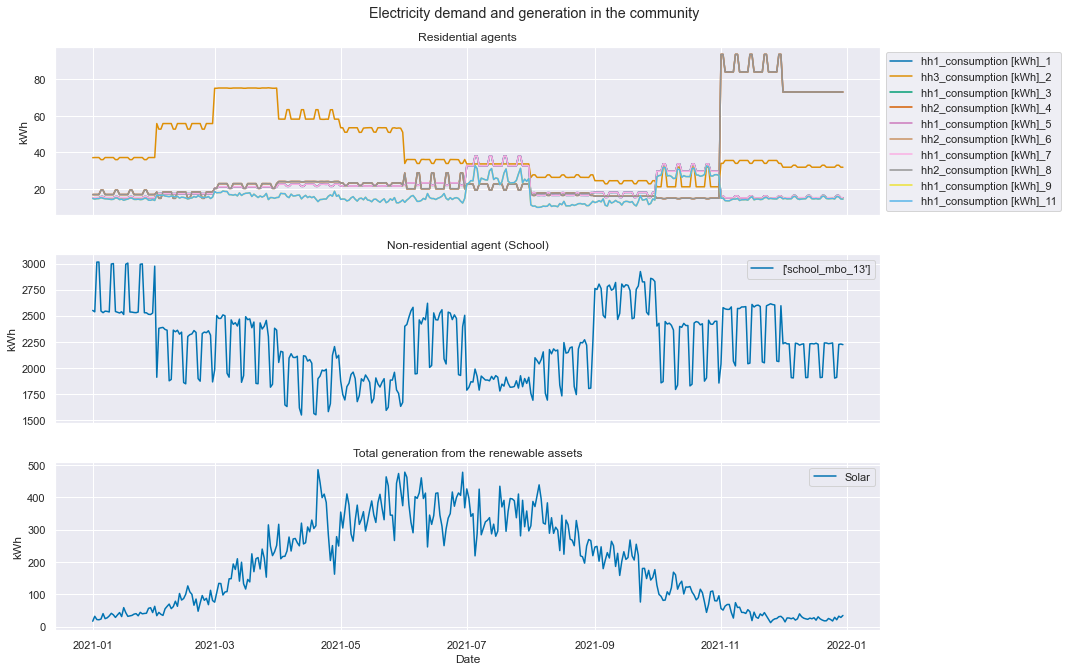

In [27]:
fig, axs = plt.subplots(3, 1, figsize=(15, 9.5), sharex=True)
sns.set_theme(palette='colorblind')
axs[0].plot(df[residential], label=residential)
axs[0].title.set_text('Residential agents')

axs[1].plot(df[non_residential], label=non_residential)
axs[1].title.set_text('Non-residential agent (School)')

axs[2].plot(total_generation, label='Solar')
axs[2].title.set_text('Total generation from the renewable assets')

plt.xlabel('Date')
axs[0].set_ylabel('kWh')
axs[1].set_ylabel('kWh')
axs[2].set_ylabel('kWh')
fig.suptitle('Electricity demand and generation in the community')

axs[0].legend(bbox_to_anchor=(1, 1))
axs[1].legend()
axs[2].legend()

plt.tight_layout()
fig.savefig('figures_validation/micro_extreme_low_uncertainty_demand_generation.png', dpi=300)

In [28]:
shifted_load = extract_df_from_json(results, 'M3: shifted_load')
shifted_load['date'] = pd.to_datetime(shifted_load['date'], format='%Y-%m-%d')
shifted_load.set_index('date', inplace=True, drop=True)

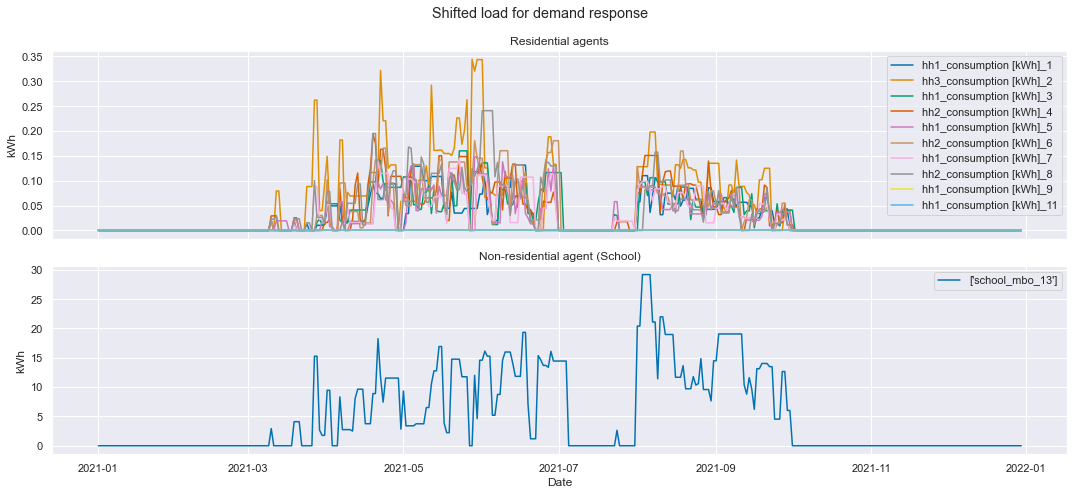

In [29]:
fig, axs = plt.subplots(2, 1, figsize=(15, 7), sharex=True)
sns.set_theme(palette='colorblind')
axs[0].plot(shifted_load[residential], label=residential)
axs[0].title.set_text('Residential agents')
axs[1].plot(shifted_load[non_residential], label=non_residential)
axs[1].title.set_text('Non-residential agent (School)')
plt.xlabel('Date')
axs[0].set_ylabel('kWh')
axs[1].set_ylabel('kWh')
fig.suptitle('Shifted load for demand response')

axs[0].legend(bbox_to_anchor=(1, 1))
axs[1].legend()

plt.tight_layout()
fig.savefig('figures_validation/micro_extreme_low_uncertainty_shifted_load.png', dpi=300)

In [30]:
energy_costs = extract_df_from_json(results, 'M6: energy_costs')
energy_costs['date'] = pd.to_datetime(energy_costs['date'], format='%Y-%m-%d')
energy_costs.set_index('date', inplace=True, drop=True)

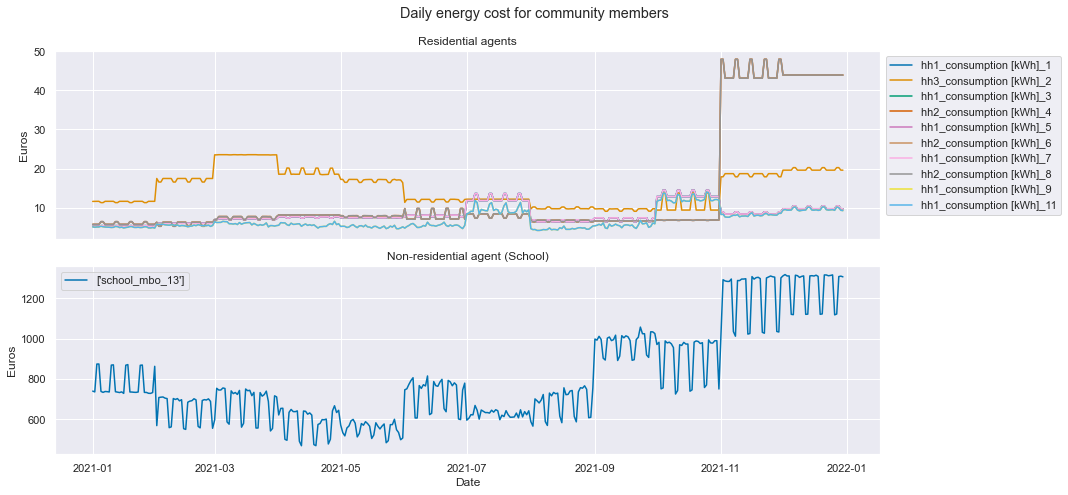

In [31]:
fig, axs = plt.subplots(2, 1, figsize=(15, 7), sharex=True)
sns.set_theme(palette='colorblind')
axs[0].plot(energy_costs[residential], label=residential)
axs[0].title.set_text('Residential agents')
axs[1].plot(energy_costs[non_residential], label=non_residential)
axs[1].title.set_text('Non-residential agent (School)')
plt.xlabel('Date')
axs[0].set_ylabel('Euros')
axs[1].set_ylabel('Euros')
fig.suptitle('Daily energy cost for community members')

axs[0].legend(bbox_to_anchor=(1, 1))
axs[1].legend()

plt.tight_layout()
fig.savefig('figures_validation/micro_extreme_low_uncertainty_electricity_cost.png', dpi=300)

### Performing test for another set of extreme uncertainties

In [32]:
model = EnergyCommunity(levers=None,  # Default values
                        uncertainties=uncertainties_high,
                        agents_list=agent_list,
                        start_date=None)  # Default values

In [33]:
results = model.run_simulation(steps=365, time_tracking=True)

Run time: 33.46 seconds
Simulation completed!


In [34]:
df = pd.DataFrame()
for item in results['M1: realised_demand']:
    df = df.append(item, ignore_index=True)
df['date'] = pd.to_datetime(results['date'], format='%Y-%m-%d')
df = df[1:]
df.set_index('date', inplace=True)

total_generation = extract_df_from_json(results, 'M4: total_generation')
total_generation['date'] = pd.to_datetime(total_generation['date'], format='%Y-%m-%d')
total_generation.set_index('date', inplace=True, drop=True)

residential = df.columns.to_list()[:-1]
non_residential = df.columns.to_list()[-1:]

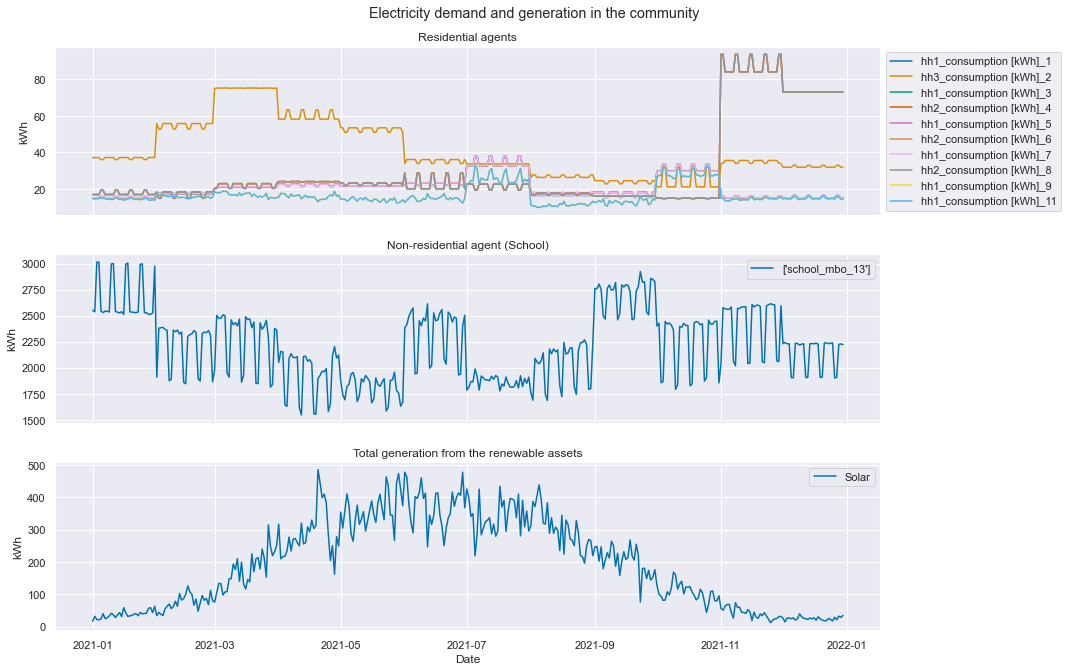

In [35]:
fig, axs = plt.subplots(3, 1, figsize=(15, 9.5), sharex=True)
sns.set_theme(palette='colorblind')
axs[0].plot(df[residential], label=residential)
axs[0].title.set_text('Residential agents')

axs[1].plot(df[non_residential], label=non_residential)
axs[1].title.set_text('Non-residential agent (School)')

axs[2].plot(total_generation, label='Solar')
axs[2].title.set_text('Total generation from the renewable assets')

plt.xlabel('Date')
axs[0].set_ylabel('kWh')
axs[1].set_ylabel('kWh')
axs[2].set_ylabel('kWh')
fig.suptitle('Electricity demand and generation in the community')

axs[0].legend(bbox_to_anchor=(1, 1))
axs[1].legend()
axs[2].legend()

plt.tight_layout()
fig.savefig('figures_validation/micro_extreme_high_uncertainty_demand_generation.png', dpi=300)

In [36]:
shifted_load = extract_df_from_json(results, 'M3: shifted_load')
shifted_load['date'] = pd.to_datetime(shifted_load['date'], format='%Y-%m-%d')
shifted_load.set_index('date', inplace=True, drop=True)

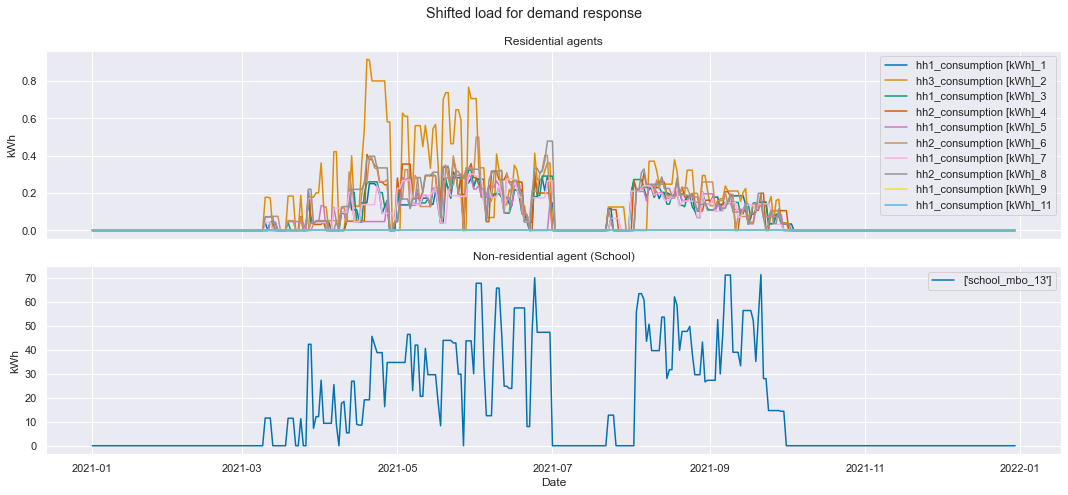

In [37]:
fig, axs = plt.subplots(2, 1, figsize=(15, 7), sharex=True)
sns.set_theme(palette='colorblind')
axs[0].plot(shifted_load[residential], label=residential)
axs[0].title.set_text('Residential agents')
axs[1].plot(shifted_load[non_residential], label=non_residential)
axs[1].title.set_text('Non-residential agent (School)')
plt.xlabel('Date')
axs[0].set_ylabel('kWh')
axs[1].set_ylabel('kWh')
fig.suptitle('Shifted load for demand response')
axs[0].legend(bbox_to_anchor=(1, 1))
axs[1].legend()
plt.tight_layout()
fig.savefig('figures_validation/micro_extreme_high_uncertainty_shifted_load.png', dpi=300)

In [38]:
energy_costs = extract_df_from_json(results, 'M6: energy_costs')
energy_costs['date'] = pd.to_datetime(energy_costs['date'], format='%Y-%m-%d')
energy_costs.set_index('date', inplace=True, drop=True)

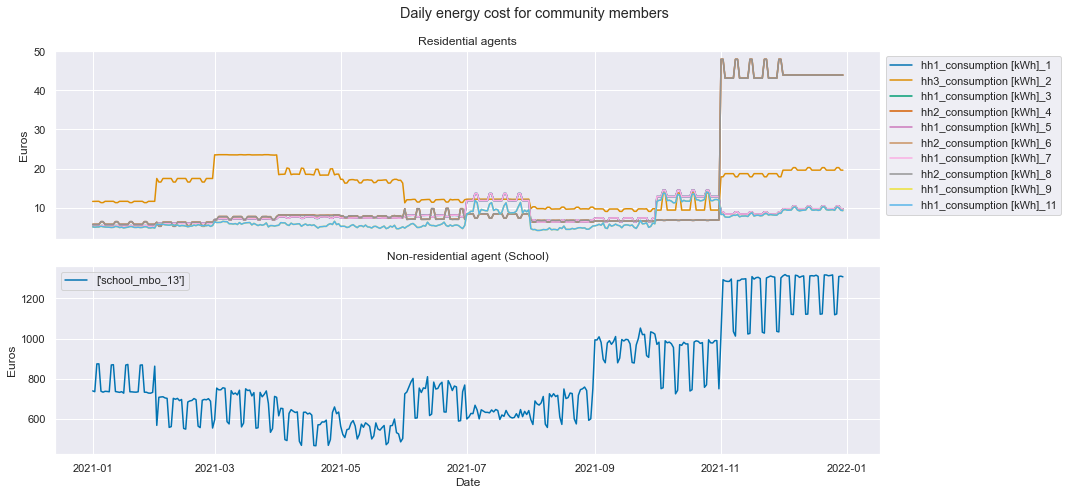

In [39]:
fig, axs = plt.subplots(2, 1, figsize=(15, 7), sharex=True)
sns.set_theme(palette='colorblind')
axs[0].plot(energy_costs[residential], label=residential)
axs[0].title.set_text('Residential agents')
axs[1].plot(energy_costs[non_residential], label=non_residential)
axs[1].title.set_text('Non-residential agent (School)')
plt.xlabel('Date')
axs[0].set_ylabel('Euros')
axs[1].set_ylabel('Euros')
fig.suptitle('Daily energy cost for community members')

axs[0].legend(bbox_to_anchor=(1, 1))
axs[1].legend()

plt.tight_layout()
fig.savefig('figures_validation/micro_extreme_high_uncertainty_electricity_cost.png', dpi=300)

## 2. Macro validation

For macro validation, same setup from micro validation is used. In macro validation, the model level outcomes are evaluated to study the system behaviour. If the behaviour exhibited under extreme policy levers and uncertainties is expected and explainable, the test results are concluded as positive.

### 2.1 Extreme lever test

In [57]:
model = EnergyCommunity(levers=levers_low,
                        uncertainties=None,  #Default values
                        agents_list=agent_list,
                        start_date=None)  # Default values

In [58]:
results = model.run_simulation(steps=365, time_tracking=True)

Run time: 30.71 seconds
Simulation completed!


In [59]:
df = pd.DataFrame()
for item in results['M1: realised_demand']:
    df = df.append(item, ignore_index=True)
df['date'] = pd.to_datetime(results['date'], format='%Y-%m-%d')
df = df[1:]
df.set_index('date', inplace=True)

total_generation = extract_df_from_json(results, 'M4: total_generation')
total_generation['date'] = pd.to_datetime(total_generation['date'], format='%Y-%m-%d')
total_generation.set_index('date', inplace=True, drop=True)

residential = df.columns.to_list()[:-1]
non_residential = df.columns.to_list()[-1:]

df['residential'] = df.loc[:, residential].sum(axis=1)
columns = ['residential', 'school_mbo_13']

energy_costs = extract_df_from_json(results, 'M6: energy_costs')
energy_costs['date'] = pd.to_datetime(energy_costs['date'], format='%Y-%m-%d')
energy_costs.set_index('date', inplace=True, drop=True)
energy_costs['residential'] = energy_costs.loc[:, residential].sum(axis=1)

shifted_load = extract_df_from_json(results, 'M3: shifted_load')
shifted_load['date'] = pd.to_datetime(shifted_load['date'], format='%Y-%m-%d')
shifted_load.set_index('date', inplace=True, drop=True)
shifted_load['shifted_load'] = shifted_load.sum(axis=1)



df['residential consumption'] = df['residential']
df['non-residential consumption'] = df['school_mbo_13']
df['generation from solar assets'] = total_generation.iloc[:,0]
df['load shifted by demand response'] = shifted_load['shifted_load']

columns = ['residential consumption', 'non-residential consumption', 'generation from solar assets', 'load shifted by demand response']

df = df[columns]

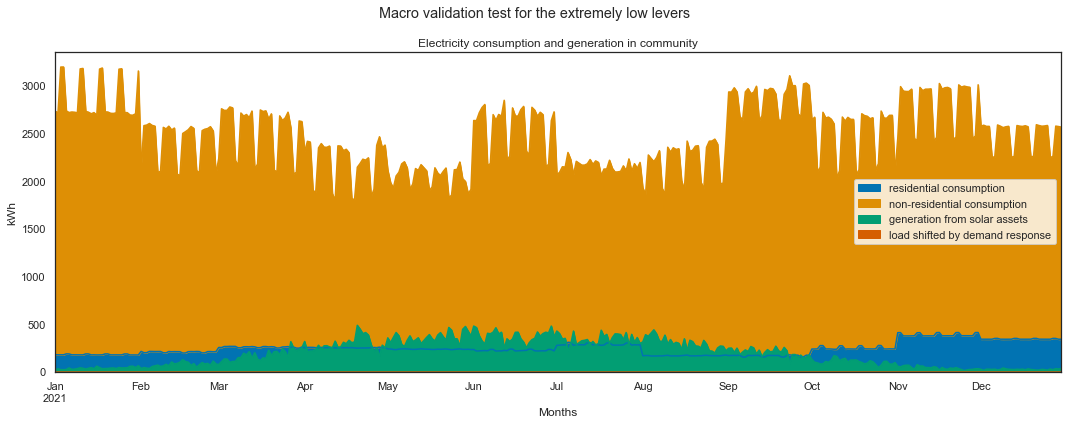

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6), sharex=True)
sns.set_theme(palette='colorblind')
sns.set_style("white")
df[['residential consumption', 'non-residential consumption']].plot(kind='area', stacked=True, ax=ax)
df[['generation from solar assets']].plot(kind='area', stacked=True, ax=ax)
df[['load shifted by demand response']].plot(kind='area', stacked=True, ax=ax)

ax.legend()
ax.set_ylabel('kWh')
ax.set_title('Electricity consumption and generation in community')
fig.suptitle('Macro validation test for the extremely low levers')

plt.xlabel('Months')
plt.ylabel('kWh')

plt.tight_layout()
fig.savefig('figures_validation/macro_extreme_low_lever.png', dpi=300)

### Performing test for another set of extreme levers


In [61]:
model = EnergyCommunity(levers=levers_high,
                        uncertainties=None,  #Default values
                        agents_list=agent_list,
                        start_date=None)  # Default values

In [62]:
results = model.run_simulation(steps=365, time_tracking=True)

Run time: 41.91 seconds
Simulation completed!


In [63]:
df = pd.DataFrame()
for item in results['M1: realised_demand']:
    df = df.append(item, ignore_index=True)
df['date'] = pd.to_datetime(results['date'], format='%Y-%m-%d')
df = df[1:]
df.set_index('date', inplace=True)

total_generation = extract_df_from_json(results, 'M4: total_generation')
total_generation['date'] = pd.to_datetime(total_generation['date'], format='%Y-%m-%d')
total_generation.set_index('date', inplace=True, drop=True)

residential = df.columns.to_list()[:-1]
non_residential = df.columns.to_list()[-1:]

df['residential'] = df.loc[:, residential].sum(axis=1)
columns = ['residential', 'school_mbo_13']

energy_costs = extract_df_from_json(results, 'M6: energy_costs')
energy_costs['date'] = pd.to_datetime(energy_costs['date'], format='%Y-%m-%d')
energy_costs.set_index('date', inplace=True, drop=True)
energy_costs['residential'] = energy_costs.loc[:, residential].sum(axis=1)

shifted_load = extract_df_from_json(results, 'M3: shifted_load')
shifted_load['date'] = pd.to_datetime(shifted_load['date'], format='%Y-%m-%d')
shifted_load.set_index('date', inplace=True, drop=True)
shifted_load['shifted_load'] = shifted_load.sum(axis=1)



df['residential consumption'] = df['residential']
df['non-residential consumption'] = df['school_mbo_13']
df['generation from solar assets'] = total_generation.iloc[:,0]
df['load shifted by demand response'] = shifted_load['shifted_load']

columns = ['residential consumption', 'non-residential consumption', 'generation from solar assets', 'load shifted by demand response']

df = df[columns]

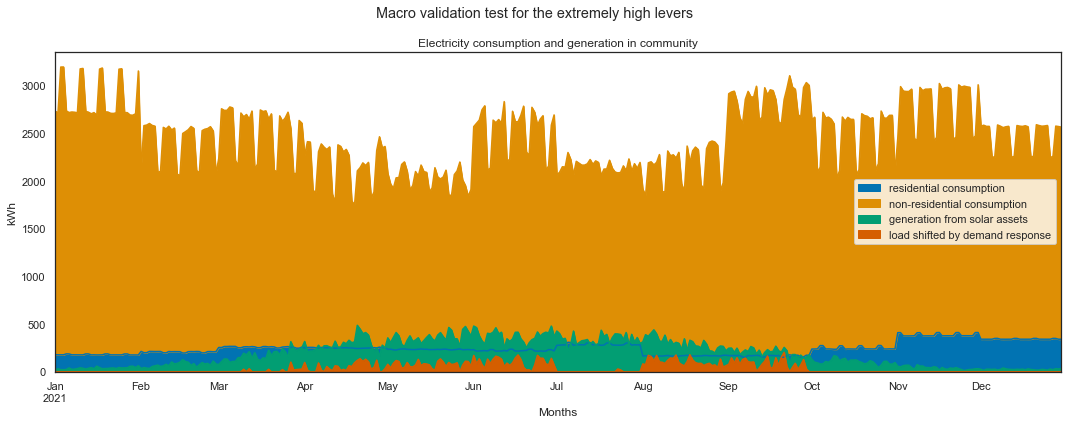

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6), sharex=True)
sns.set_theme(palette='colorblind')
sns.set_style("white")
df[['residential consumption', 'non-residential consumption']].plot(kind='area', stacked=True, ax=ax)
df[['generation from solar assets']].plot(kind='area', stacked=True, ax=ax)
df[['load shifted by demand response']].plot(kind='area', stacked=True, ax=ax)

ax.legend()
ax.set_ylabel('kWh')
ax.set_title('Electricity consumption and generation in community')
fig.suptitle('Macro validation test for the extremely high levers')

plt.xlabel('Months')
plt.ylabel('kWh')

plt.tight_layout()
fig.savefig('figures_validation/macro_extreme_high_lever.png', dpi=300)

### 2.2 Extreme uncertainty test

In [65]:
model = EnergyCommunity(levers=None,  # Default values
                        uncertainties=uncertainties_low,
                        agents_list=agent_list,
                        start_date=None)  # Default values

In [66]:
results = model.run_simulation(steps=365, time_tracking=True)

Run time: 34.86 seconds
Simulation completed!


In [67]:
df = pd.DataFrame()
for item in results['M1: realised_demand']:
    df = df.append(item, ignore_index=True)
df['date'] = pd.to_datetime(results['date'], format='%Y-%m-%d')
df = df[1:]
df.set_index('date', inplace=True)

total_generation = extract_df_from_json(results, 'M4: total_generation')
total_generation['date'] = pd.to_datetime(total_generation['date'], format='%Y-%m-%d')
total_generation.set_index('date', inplace=True, drop=True)

residential = df.columns.to_list()[:-1]
non_residential = df.columns.to_list()[-1:]

df['residential'] = df.loc[:, residential].sum(axis=1)
columns = ['residential', 'school_mbo_13']

energy_costs = extract_df_from_json(results, 'M6: energy_costs')
energy_costs['date'] = pd.to_datetime(energy_costs['date'], format='%Y-%m-%d')
energy_costs.set_index('date', inplace=True, drop=True)
energy_costs['residential'] = energy_costs.loc[:, residential].sum(axis=1)

shifted_load = extract_df_from_json(results, 'M3: shifted_load')
shifted_load['date'] = pd.to_datetime(shifted_load['date'], format='%Y-%m-%d')
shifted_load.set_index('date', inplace=True, drop=True)
shifted_load['shifted_load'] = shifted_load.sum(axis=1)



df['residential consumption'] = df['residential']
df['non-residential consumption'] = df['school_mbo_13']
df['generation from solar assets'] = total_generation.iloc[:,0]
df['load shifted by demand response'] = shifted_load['shifted_load']

columns = ['residential consumption', 'non-residential consumption', 'generation from solar assets', 'load shifted by demand response']

df = df[columns]

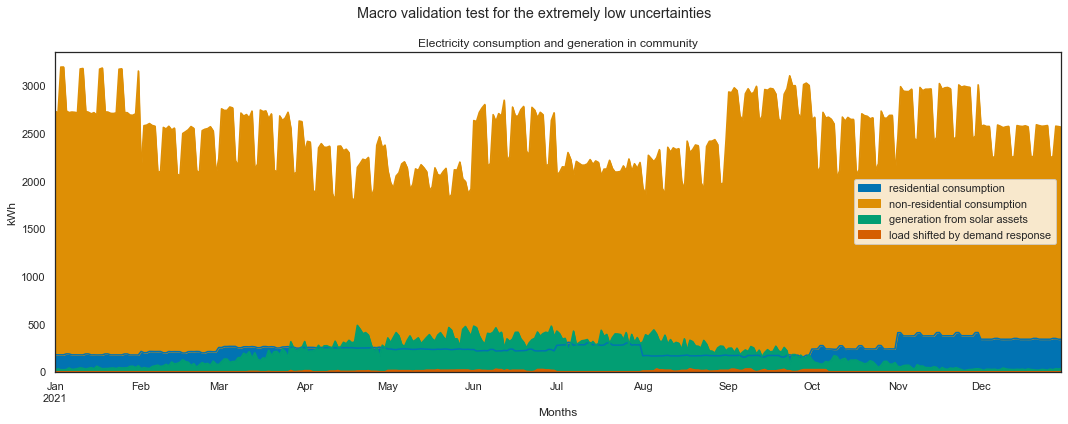

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6), sharex=True)
sns.set_theme(palette='colorblind')
sns.set_style("white")
df[['residential consumption', 'non-residential consumption']].plot(kind='area', stacked=True, ax=ax)
df[['generation from solar assets']].plot(kind='area', stacked=True, ax=ax)
df[['load shifted by demand response']].plot(kind='area', stacked=True, ax=ax)

ax.legend()
ax.set_ylabel('kWh')
ax.set_title('Electricity consumption and generation in community')
fig.suptitle('Macro validation test for the extremely low uncertainties')

plt.xlabel('Months')
plt.ylabel('kWh')

plt.tight_layout()
fig.savefig('figures_validation/macro_extreme_low_uncertainty.png', dpi=300)

### Performing test for another set of extreme uncertainties


In [69]:
model = EnergyCommunity(levers=None,  # Default values
                        uncertainties=uncertainties_high,
                        agents_list=agent_list,
                        start_date=None)  # Default values

In [70]:
results = model.run_simulation(steps=365, time_tracking=True)

Run time: 34.14 seconds
Simulation completed!


In [71]:
df = pd.DataFrame()
for item in results['M1: realised_demand']:
    df = df.append(item, ignore_index=True)
df['date'] = pd.to_datetime(results['date'], format='%Y-%m-%d')
df = df[1:]
df.set_index('date', inplace=True)

total_generation = extract_df_from_json(results, 'M4: total_generation')
total_generation['date'] = pd.to_datetime(total_generation['date'], format='%Y-%m-%d')
total_generation.set_index('date', inplace=True, drop=True)

residential = df.columns.to_list()[:-1]
non_residential = df.columns.to_list()[-1:]

df['residential'] = df.loc[:, residential].sum(axis=1)
columns = ['residential', 'school_mbo_13']

energy_costs = extract_df_from_json(results, 'M6: energy_costs')
energy_costs['date'] = pd.to_datetime(energy_costs['date'], format='%Y-%m-%d')
energy_costs.set_index('date', inplace=True, drop=True)
energy_costs['residential'] = energy_costs.loc[:, residential].sum(axis=1)

shifted_load = extract_df_from_json(results, 'M3: shifted_load')
shifted_load['date'] = pd.to_datetime(shifted_load['date'], format='%Y-%m-%d')
shifted_load.set_index('date', inplace=True, drop=True)
shifted_load['shifted_load'] = shifted_load.sum(axis=1)



df['residential consumption'] = df['residential']
df['non-residential consumption'] = df['school_mbo_13']
df['generation from solar assets'] = total_generation.iloc[:,0]
df['load shifted by demand response'] = shifted_load['shifted_load']

columns = ['residential consumption', 'non-residential consumption', 'generation from solar assets', 'load shifted by demand response']

df = df[columns]

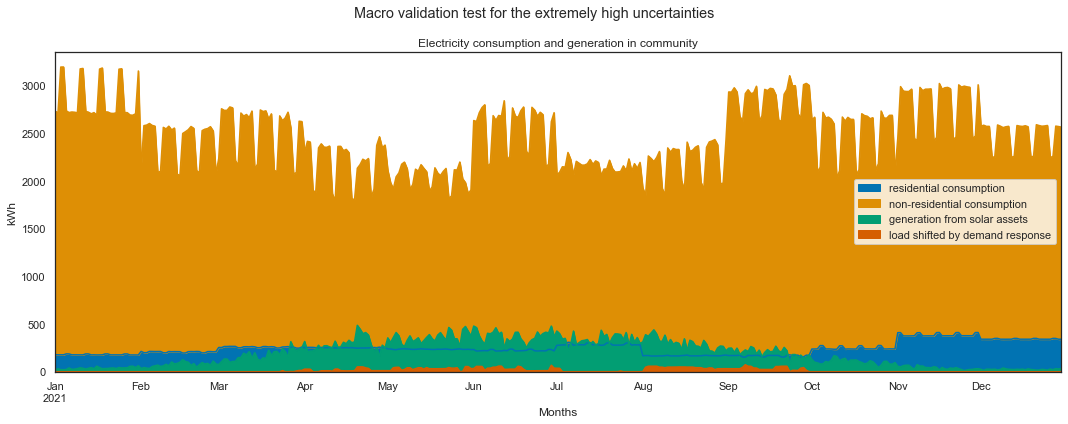

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6), sharex=True)
sns.set_theme(palette='pastel')
sns.set_style("white")
df[['residential consumption', 'non-residential consumption']].plot(kind='area', stacked=True, ax=ax)
df[['generation from solar assets']].plot(kind='area', stacked=True, ax=ax)
df[['load shifted by demand response']].plot(kind='area', stacked=True, ax=ax)

ax.legend()
ax.set_ylabel('kWh')
ax.set_title('Electricity consumption and generation in community')
fig.suptitle('Macro validation test for the extremely high uncertainties')

plt.xlabel('Months')
plt.ylabel('kWh')

plt.tight_layout()
fig.savefig('figures_validation/macro_extreme_high_uncertainty.png', dpi=300)